## Training the Encoder unsupervisedly
This is the jupyter notebook to train the encoding part of the network, in an unsupervised manner.

In [1]:
import multimodal_deep_belief_network as DBN
import torch
import torchvision
import custom_mnist_dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/emmv1d18/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/emmv1d18/anaconda3/

## Loading the training data and displaying it
We use a custom mnist dataset function to integrate the one-hot encoding to it, along with functions to do the supervised fine-tuning.

In [30]:
batch_size = 32
mnist_data = custom_mnist_dataset.MNIST('/home/emmv1d18/Work/Databases', 
                                        train=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1307], std=[0.3081])]),
                                        target_transform=custom_mnist_dataset.to_one_hot(), 
                                        download=True)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

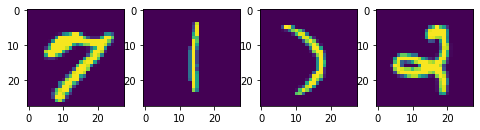

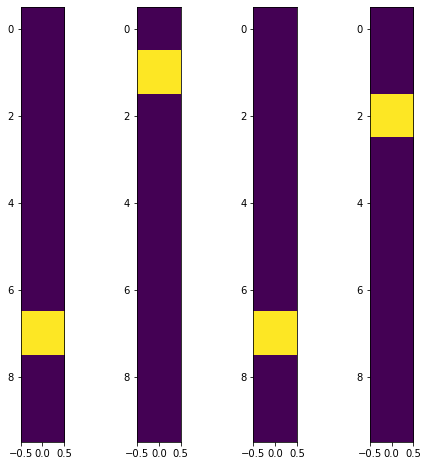

In [35]:
# First we load the training data.
data = next(iter(data_loader))
tgt = data['target']
img = data['image']
# Now we display the first four training tuples.
columns = 4
rows = 1
fig=plt.figure(figsize=(8, 8))
for i in range(1, (columns*rows)+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[i][0])
plt.show()
fig=plt.figure(figsize=(8, 8))
for i in range(1, (columns*rows)+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(tgt[i][0])
plt.show()

## Creating the DBN and adding layers
We will now instanciate the multimodal DBN object. Only the number of modalities is needed.
Then, we add layers to the DBN, modality-wise. It is important to note that the layers have to be added in order and have a different name inside the same modality.
After, we initialise layers with the saved parameters. In this demo, they are all provided but a fresh training does not need any call of initialisation function.
Finally, we move the network to a device. See pytorch CUDA semantics (https://pytorch.org/docs/stable/notes/cuda.html) for more info.

In [5]:
dbn = DBN.multimod_dbn(number_of_modalities=2)

dbn.add_layer(name='rbm_img_0', type_of_layer='convolutional', modality =0, gaussian_units = True, visible_units = [1,28,28],  filters_properties = {'f_number':32, 'f_height':3,'f_width':3,'stride':1})
dbn.add_layer(name='rbm_img_1', type_of_layer='convolutional', modality =0, gaussian_units = True, visible_units = [32,26,26], filters_properties = {'f_number':32, 'f_height':2,'f_width':2,'stride':2})
dbn.add_layer(name='rbm_img_2', type_of_layer='convolutional', modality =0, gaussian_units = True, visible_units = [32,13,13], filters_properties = {'f_number':64, 'f_height':4,'f_width':4,'stride':1})
dbn.add_layer(name='rbm_img_3', type_of_layer='convolutional', modality =0, gaussian_units = True, visible_units = [64,10,10], filters_properties = {'f_number':64, 'f_height':2,'f_width':2,'stride':2})

dbn.add_layer(name='rbm_tgt_0', type_of_layer='convolutional', modality =1, gaussian_units = False, visible_units = [1,10,1], filters_properties = {'f_number':16, 'f_height':4,'f_width':1,'stride':1})
dbn.add_layer(name='rbm_tgt_1', type_of_layer='convolutional', modality =1, gaussian_units = True, visible_units = [16,7,1],  filters_properties = {'f_number':32, 'f_height':3,'f_width':1,'stride':1})

dbn.add_layer(name='joint', type_of_layer='joint_convolutional', gaussian_units = [True,True], visible_units = [[64,5,5],[32,5,1]], 
              filters_properties = [{'f_number':64, 'f_height':5,'f_width':5,'stride':1},{'f_number':64, 'f_height':5,'f_width':1,'stride':1}])

dbn.initialise_layer('rbm_img_0', './saves_mnist_demo/rbm0_img_3x3x1x32', modality = '0')
dbn.initialise_layer('rbm_img_1', './saves_mnist_demo/rbm1_img_2x2x2x32', modality = '0')
dbn.initialise_layer('rbm_img_2', './saves_mnist_demo/rbm2_img_4x4x1x64', modality = '0')
dbn.initialise_layer('rbm_img_3', './saves_mnist_demo/rbm3_img_2x2x2x64', modality = '0')
dbn.initialise_layer('rbm_tgt_0', './saves_mnist_demo/rbm0_tgt_4x1x1x16', modality = '1')
dbn.initialise_layer('rbm_tgt_1', './saves_mnist_demo/rbm1_tgt_3x1x1x32', modality = '1')
dbn.initialise_layer('joint', './saves_mnist_demo/joint')

device =1
dbn.move_network_to_device(device)

## Training the network
Now is the time to train the network. The following block shows how to train the network in a greedy, layer-wise manner.
Note that training the joint layer requires the two modalities already trained.

## Observing the inference result
Calling the network_inference method to return a list containing the inferred modalities. They can now be easily displayed.

In [21]:
inferred_data = dbn.network_inference([img.cuda(device).float(),tgt.cuda(device).float()])